# Data and Web Mining
## Kaggle ft Child Institute: problematic internet use 
alleneremo e metteremo a confronto due modelli. uno ad albero e uno basato su rete neurale.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from data_cleaning_module import prepare_data, augment_data, correlation_matrix1, correlation_matrix2, feature_importance_and_mutual_info, backward_elimination
from model0_baseline_module import run_baseline
# from model1_XGBoost_module import run_model1
from model2_ann_module import run_nn, prepare_X, impute_missing_values, rf_cascade, tune_hyperparameters
SEED = 42 # global random seed for reproducibility

# Preparazione dati
Le prime cosa da fare a partire dai dati grezzi sono:
1. split tra train/validation/test.
2. trasformazione delle variabili categoriche in variabili numeriche
3. eliminazione delle features con troppi NaN, non predittive o ridondanti.

In particolare, abbiamo contato il numero di missing values per ogni colonna presente nel train, eliminando tutte quelle con una percentuale di missing values > 50%. 

Di variabili categoriche erano presenti solamente quelle stagionali. Abbiamo deciso di adottare un approccio ordinale per mappare le stagioni in numeri: winter:0, spring:11, summer:2, fall:3, NaN:NaN.

Dopodiché abbiamo fatto la matrice di correlazione tra tutte le colonne rimanenti, eliminando le features ridondanti (correlazione > 0.9)

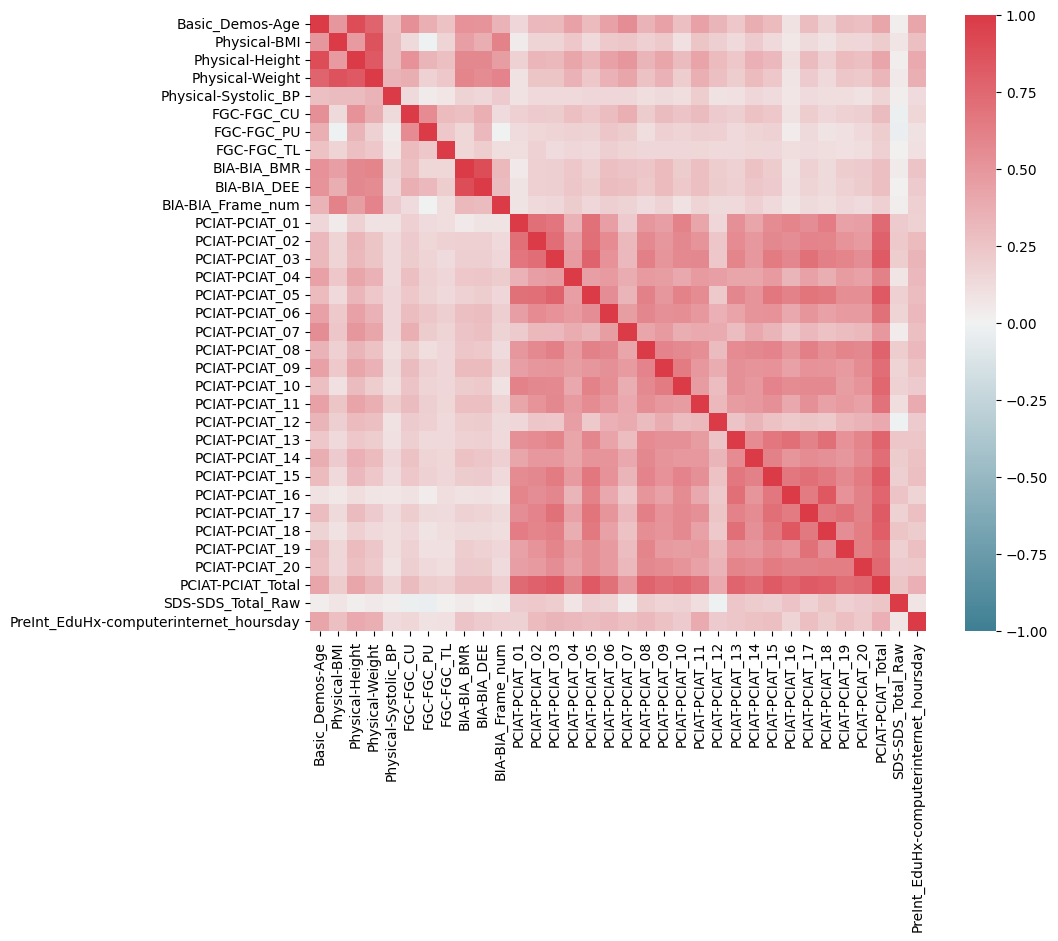

In [3]:
X_train, y_train, X_val, y_val, X_test, y_test = prepare_data("../data/train.csv", SEED)
X_train_filtered = correlation_matrix1(X_train, y_train)

Per scremare ulteriormente le features (per avere maggior interpretabilità e minore complessità computazionale), abbiamo allenato una random forest in cross validation, per valutare la features importance. Abbiamo anche dato un'occhiata all'analisi statistica "mutual information", che non dipende dal modello, ma misura "quanto sapere la feature aiuta a prevedere la classe". Messa in grafico col NaN ratio, dà anch'essa una buona misura di cosa sia significativo o meno, per confrontarlo coi risultati ottenuti dalla feature importance appena calcolata.

Mutual Information e Feature Importance sono concetti simili, ma non equivalenti:
* La Mutual Information valuta la dipendenza tra una singola feature e la label, senza tenere conto di correlazioni tra le feature.
* La Feature Importance calcolata su un modello ad albero (nello specifico del nostro caso, Random Forest) misura quanto una feature contribuisce alla goodness durante le split, quindi nel contesto del modello.

Entrambi gli approcci presentano limiti, ma in modo opposto:

* Se due feature sono fortemente correlate tra loro, la Feature Importance può "dividersi" tra le due. Una potrebbe risultare poco importante semplicemente perché l'informazione è già stata assorbita dall'altra nei rami precedenti.
* La Mutual Information, invece, non tiene conto delle combinazioni tra feature. Una singola feature può avere MI ≈ 0, ma una combinazione di due feature può essere altamente predittiva. Un esempio è `Y = A XOR B`: A e B da sole non predicono Y, ma la loro combinazione sì. Scartandone una si perderebbe completamente la capacità predittiva.

Per questo motivo è utile valutare visivamente entrambe le misure nelle fasi preliminari, prima di prendere decisioni definitive sull'eliminazione delle feature.

c:\Users\Dav\Uni_Lavoro\data-web-mining-project\src\data_cleaning_module.py:153: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


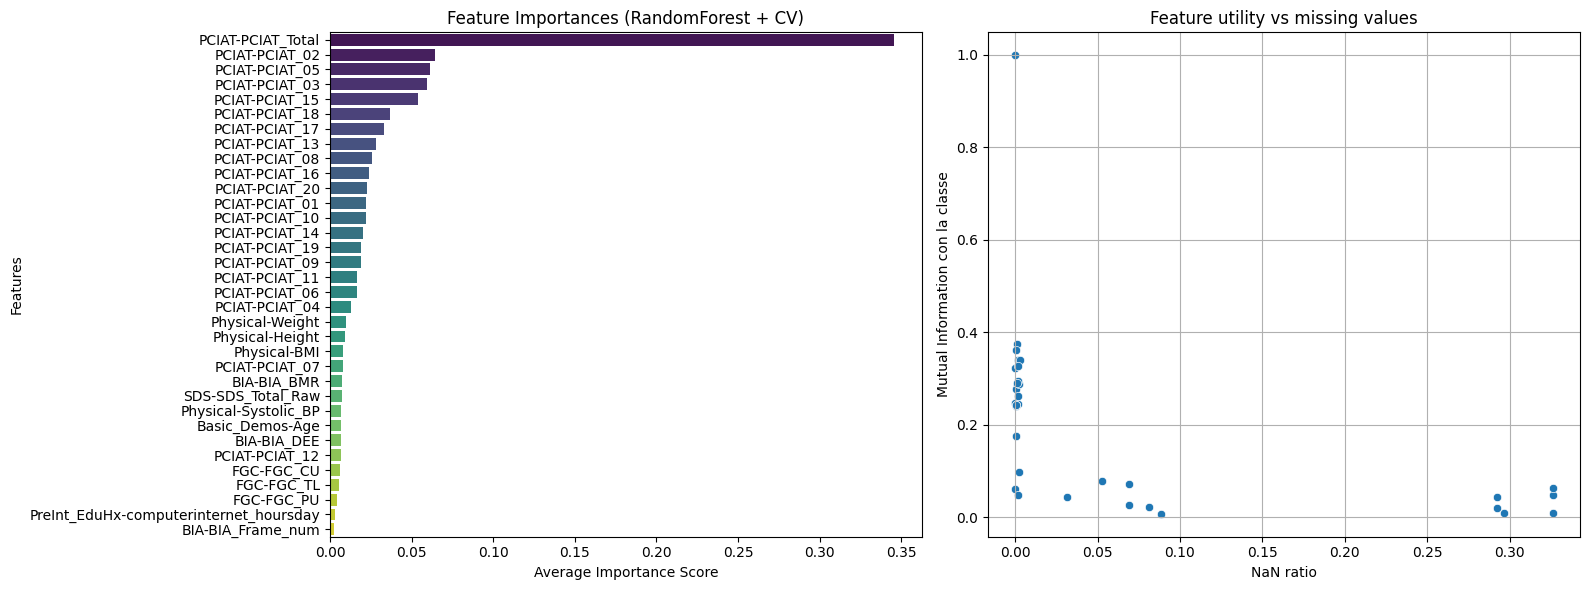

Feature con NaN ratio > 0.25:
FGC-FGC_CU           0.043756
FGC-FGC_PU           0.010125
FGC-FGC_TL           0.020724
BIA-BIA_BMR          0.048159
BIA-BIA_DEE          0.064550
BIA-BIA_Frame_num    0.009929
dtype: float64

Feature con alta mutual information, ordinate in modo decrescente:
PCIAT-PCIAT_Total    0.999244
PCIAT-PCIAT_03       0.375937
PCIAT-PCIAT_05       0.362514
PCIAT-PCIAT_15       0.340810
PCIAT-PCIAT_17       0.339850
PCIAT-PCIAT_18       0.326932
PCIAT-PCIAT_02       0.323280
PCIAT-PCIAT_16       0.295106
PCIAT-PCIAT_20       0.291679
PCIAT-PCIAT_13       0.288049
PCIAT-PCIAT_08       0.286806
PCIAT-PCIAT_10       0.277102
PCIAT-PCIAT_19       0.262353
PCIAT-PCIAT_01       0.247588
PCIAT-PCIAT_09       0.244678
PCIAT-PCIAT_11       0.243194
PCIAT-PCIAT_14       0.243164
PCIAT-PCIAT_06       0.241397
dtype: float64


(Basic_Demos-Age                           0.006801
 Physical-BMI                              0.007836
 Physical-Height                           0.009015
 Physical-Weight                           0.009602
 Physical-Systolic_BP                      0.006975
 FGC-FGC_CU                                0.006304
 FGC-FGC_PU                                0.004268
 FGC-FGC_TL                                0.005432
 BIA-BIA_BMR                               0.007378
 BIA-BIA_DEE                               0.006739
 BIA-BIA_Frame_num                         0.002285
 PCIAT-PCIAT_01                            0.021929
 PCIAT-PCIAT_02                            0.064428
 PCIAT-PCIAT_03                            0.059198
 PCIAT-PCIAT_04                            0.013041
 PCIAT-PCIAT_05                            0.061181
 PCIAT-PCIAT_06                            0.016454
 PCIAT-PCIAT_07                            0.007818
 PCIAT-PCIAT_08                            0.025845
 PCIAT-PCIAT

In [4]:
feature_importance_and_mutual_info(X_train_filtered, y_train, SEED, 1)

Dal grafico della feature importance si nota che la feature che contribuisce di più alla predizione di Sii è la variabile PCIAT-PCIAT_Total seguita dalle domande 02, 05, 03, 15, 17. Dal grafico della mutual information si possono invece fare queste osservazioni:
* Molti punti si trovano a sinistra (NaN ≈ 0), il che indica che molte feature non hanno praticamente valori mancanti.
* Alcune feature mostrano un valore di Mutual Information (MI) superiore a 0.2, segnalando una forte relazione con la label.
* Ci sono feature con il 30% di valori assenti e una MI bassa -> queste presumibilmente risultano poco informative.
* Viene confermata la presenza di almeno una feature con MI ≈ 1, fortemente predittiva della label.

Notiamo immediatamente che le features con 'mi' maggiore sono le stesse (anche se in un ordine leggermente diverso) delle feature che prima abbiamo visto essere più importanti. Ugualmente, come era facile immaginare, le feature con un NaN ratio abbastanza alto risultano anche tra le meno significative nel test della feature importance. Con questa conferma, è quindi possibile procedere all'eliminazione delle features meno importanti usando la random forest 

Ora, è chiaro che le varie 'PCIAT' sono feature che soffrono di **data leakage**. Cioè, sono informazioni quasi identiche al target, che probabilmente sono direttamente usate per definire il sii, o derivate da quest'ultimo in modo deterministico o quasi. 
Si rivela quindi necessario eliminare queste features, che oltretutto non saranno disponibili sui dati futuri. 

Essendo però estremamente significative per predire il sii, si possono usare per inferire un valore per l'sii quando quest'ultimo non è disponibile (è NaN), così da avere più dati su cui allenare il modello.

### Proxy Model
Procediamo quindi con la creazione del modello di imputazione. Dovremo quindi rifare i passaggi già eseguiti, in quanto il primo passo fatto è stato eliminare le righe con sii ignoto
1. a Partire dal dataset originale, ripetiamo i passi base di preparazione dati:
   1. separiamo train/test
   2. A partire da X_train creiamo due df distinti, di cui uno contiene le righe del training set dove sii è noto, uno dove è NaN
   3. uso le PCIAT come features e sii come target per allenare una semplice ma efficace random forest, che poi uso sul df con sii NaN.
2. A questo punto, imputiamo i valori di sii mancanti.
3. Eliminiamo quindi direttamente le colonne PCIAT, ripetendo la feature selection come fatta prima, senza che queste colonne siano coinvolte.



In [5]:
X_train_final, y_train_final, X_test, y_test = augment_data()

Righe di X_training con 'sii' noto: 2193
Righe di X_training da imputare: 975
Dataset salvati in formato CSV nella cartella 'data/'.


* `X_train_final`: contiene il set di training, totale: senza le colonne PCIAT e aumentato con le righe che inizialmente avevano sii nullo
* `y_train_final`: target del training, con tutte le righe, anche quelle imputate
* `X_test`, `y_test`: set di test, intoccati, con dati ancora grezzi

A questo punto, ci sono quasi 1000 righe in più su cui allenare i modelli.
Procediamo a rifare i passi eseguiti in precedenza riguardanti pulizia dei dati e feature importance. (cambiare le stagioni, matrice di correlazione, feature importance, nan ratio)

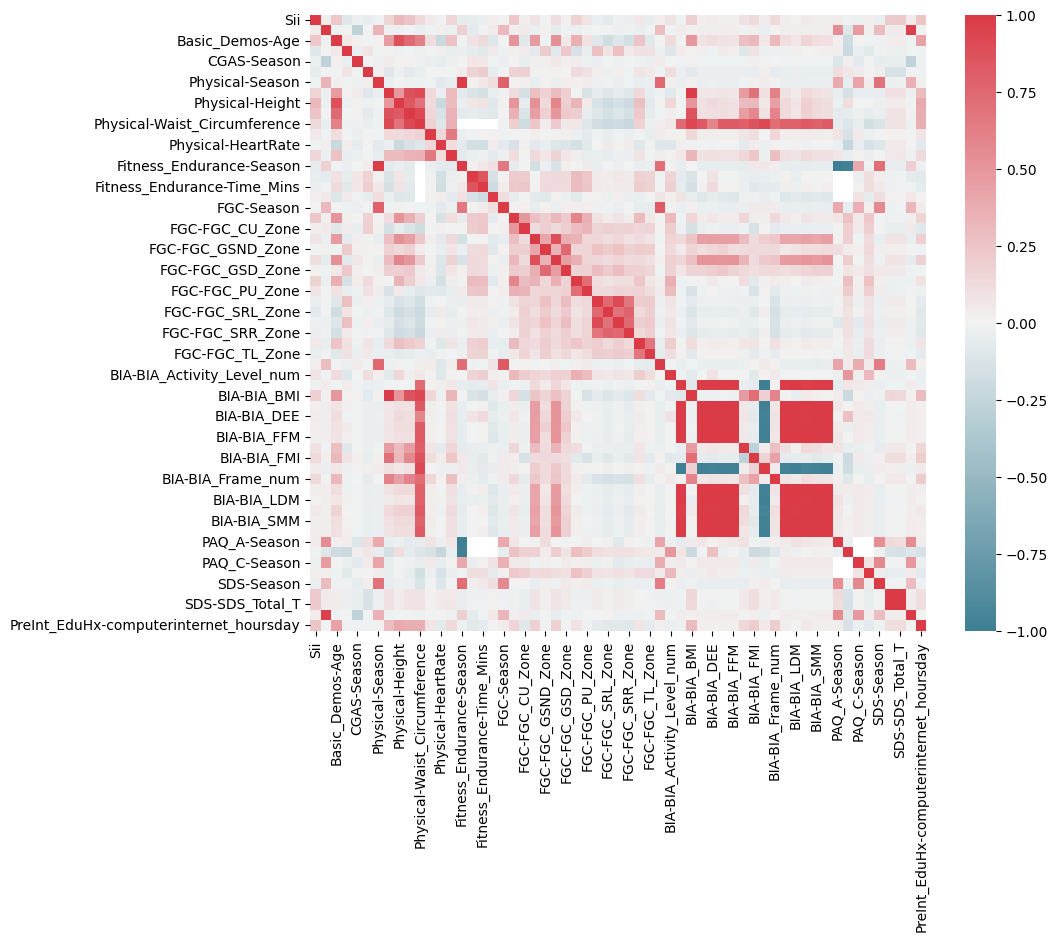

In [6]:
correlation_matrix2(X_train_final, y_train_final)

c:\Users\Dav\Uni_Lavoro\data-web-mining-project\src\data_cleaning_module.py:153: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


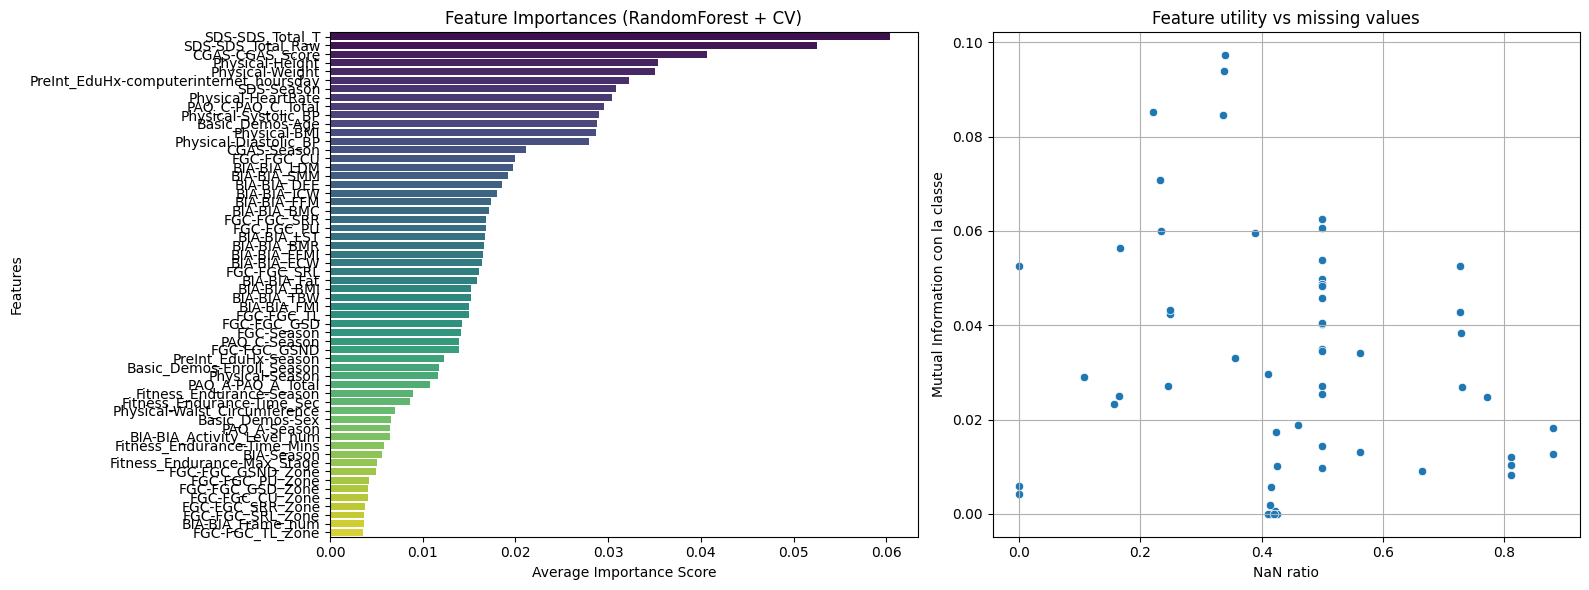

Feature con NaN ratio > 0.8:
                             NaN ratio  Mutual Info
PAQ_A-PAQ_A_Total             0.881313     0.012730
PAQ_A-Season                  0.881313     0.018190
Fitness_Endurance-Time_Sec    0.811869     0.008267
Fitness_Endurance-Time_Mins   0.811869     0.012040
Fitness_Endurance-Max_Stage   0.810922     0.010251

Feature con alta mutual information, ordinate in modo decrescente:
SDS-SDS_Total_T      0.097275
SDS-SDS_Total_Raw    0.094002
Physical-Weight      0.085147
SDS-Season           0.084694
Physical-Height      0.070808
BIA-BIA_LDM          0.062577
BIA-BIA_ICW          0.060582
dtype: float64


In [7]:
feat_imp, feat_imp_sorted = feature_importance_and_mutual_info(X_train_final, y_train_final, SEED, 2)

Si nota immediatamente quanto questi grafici siano diverso da quelli visti in precedenza: l'importance score è in generale molto più basso e decisamente meno sbilanciato di prima. Le features con NaN ratio alto non sono quelle con importance in assoluto minore, ma sono comunque nella bassa classifica, come atteso. Ugualmente alta mutual information corrisponde ad alta importance.
Data questa conferma, possiamo proseguire con l'eliminazione delle features meno significative
### Feature subset selection by elimination

Dopo aver ottenuto le importanze delle feature via Random Forest con cross-validation e aver avuto conferma dei dati anche con un secondo metodo, possiamo procedere con una selezione backward. L’idea è semplice: partiamo dal set completo di feature e rimuoviamo iterativamente quella meno importante (in base alla feature importance). A ogni rimozione, valutiamo le performance del modello su un set di validazione.

Questo approccio ha un vantaggio interessante: quando due feature sono molto correlate, la Random Forest tende a "dividersi" l’importanza tra le due, facendo sembrare ognuna meno utile individualmente. Con la backward elimination, però, appena una delle due viene rimossa, l’importanza dell’altra può impennarsi e rivelarsi cruciale. In pratica: il metodo compensa la penalizzazione delle feature ridondanti.

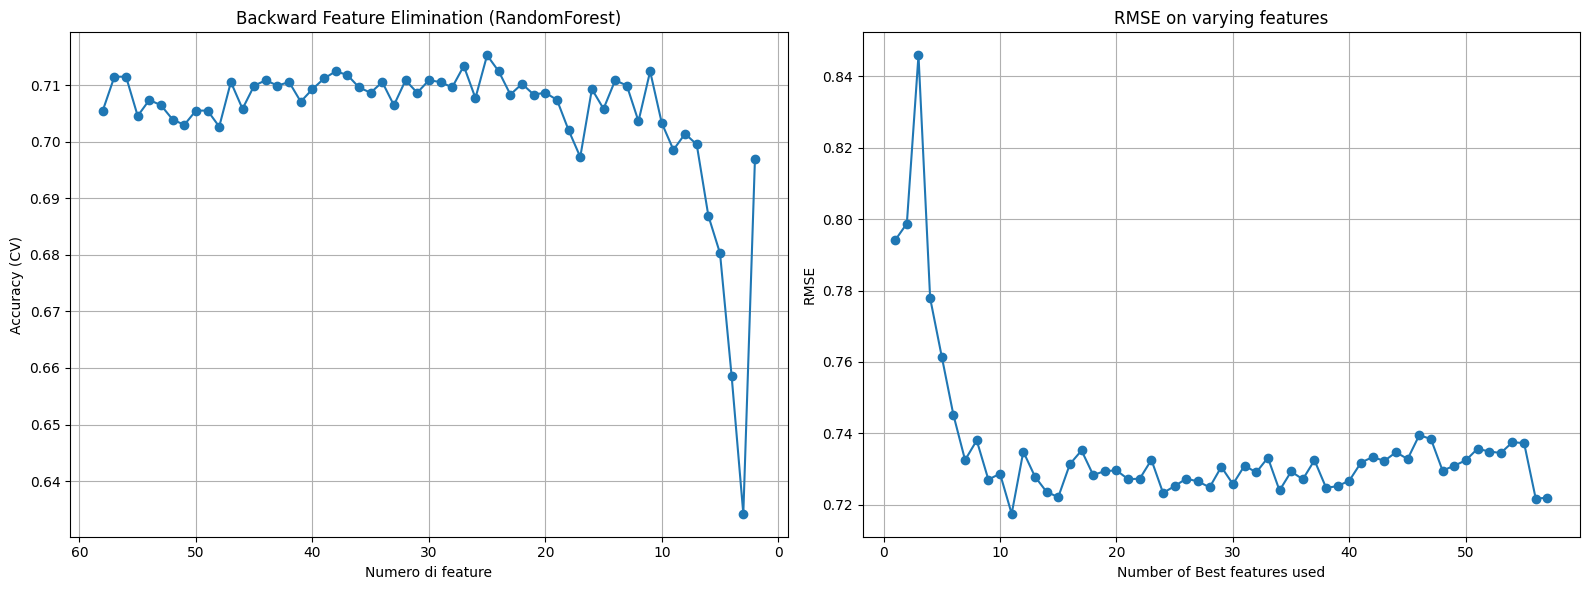

Top 11 features (RandomForest CV):
1. SDS-SDS_Total_T
2. SDS-SDS_Total_Raw
3. CGAS-CGAS_Score
4. Physical-Height
5. Physical-Weight
6. PreInt_EduHx-computerinternet_hoursday
7. SDS-Season
8. Physical-HeartRate
9. PAQ_C-PAQ_C_Total
10. Physical-Systolic_BP
11. Basic_Demos-Age
'data/X_train_final.csv' sovrascritto coi nuovi dati.


In [8]:
X_train_final = backward_elimination(X_train_final, y_train_final, feat_imp, feat_imp_sorted, SEED)

Da questi due grafici si evince che è possibile eliminare ripetutamente le features senza perdite in termini di accuracy: è chiaro come avere una decina di features sia tanto significativo quanto averle tutte, la perdita di accuracy è totalmente giustificata dalla semplificazione del modello. nel range 20-10 c'è una diminuzione leggermente più marcata, con maggiore varibilità, ma forse ugualmente accettabile. Da 11 in giù le performance calano sensibilmente. Abbiamo scelto di tenerne quindi 11. proseguiamo quindi con:
1. Mostrare le feature ordinate per importanza
2. Selezionare le prime 11 e droppare dal dataset le features non utilizzate

## Modello 0: baseline
Uno dei modelli più semplici che si possono utilizzare per eseguire delle predizioni è la moda.

In [ ]:
print("=== Model 0: Baseline ===")
run_baseline(X_train_final, y_train_final, X_test, y_test)

Ovvio che in generale vogliamo avere un'accuracy molto alta. Le classi però sono fortemente sbilanciate e, essendo un test medico, è essenziale minimizzare il numero di falsi negativi della categoria 3 (corrispondente a "severe"). Infatti, un falso positivo è meno problematico, in quanto dopo la predizione con il modello, si può eseguire un test reale sulla persona. In caso di un falso negativo, invece, si scarta a priori l'ipotesi ed è più improbabile che venga effettuato un ulteriore test. 

Il test **non verrà mai usato** se non alla fine, per valutare le performance dei due modelli e confrontarle con la baseline

## Modello 1: XGBoost

In [ ]:
print("=== Model 1 ===")
# run_model1()

## Modello 2: Rete Neurale, ensemble con RF

Avendo un dataset molto sbilanciato, abbastanza grande ma con pochissimi esempi della classe 3, prendiamo un validation di tipo stratified con il 40% dei dati di training. Standardizziamo i dati, assegnando momentaneamente il placeholder -9999 ai NaN.
Assegnamo un peso ad ogni classe in modo da ribilanciare il dataset (altrimenti il modello ricalcherà bene solo le classi 0 e 1, le più frequenti).
Creiamo quindi un modello base, che cercheremo poi di migliorare facendo tuning degli iperparametri (hidden units, activation, dropout, regolarizzazione l2, learning rate).
Usiamo due parametri di callbacks:
1. early stop se la loss di validazione non migliora per tot epoche consecutive
2. riduzione del learning rate del tot% se la loss di validazione non migliora per tot epoche



In [ ]:
# 4. Modello 2
print("=== Model 2: Neural Network ===")
y_train_final = y_train_final.astype(int)
y_test = y_test.astype(int)
X_tr, X_val, y_tr, y_val = train_test_split(X_train_final, y_train_final, test_size=0.40, stratify=y_train_final, random_state=SEED)
X_tr_scaled, X_val_scaled, class_weights = prepare_X(X_tr, X_val, y_tr, y_val, SEED)
run_nn(X=X_tr_scaled, Xv=X_val_scaled, y=y_tr, yv=y_val, weights=class_weights)

### metriche di valutazione

Ricordiamo cosa sono le varie metriche utilizzate: 

* **Accuracy**: $ = \frac{TP + TN}{TP + TN + FP + FN} $. Percentuale di predizioni corrette sul totale. Con dataset sbilanciati può essere fuorviante: basta indovinare sempre la classe più frequente per avere un valore alto
* **Precision** $ = \frac{TP}{TP + FP} $. Quanti tra i predetti positivi sono davvero positivi. Alta precisione significa pochi falsi positivi.  
* **Recall** $ = \frac{TP}{TP + FN} $ Quanti tra i positivi reali sono stati riconosciuti. Alta recall significa pochi falsi negativi.  

Se ci limitassimo a massimizzare solo la recall, basterebbe predire sempre “positivo”: in questo modo i falsi negativi sarebbero zero e la recall diventerebbe 1. Allo stesso modo, se cercassimo solo la massima precisione, potremmo predire “positivo” solo in casi rarissimi, riducendo i falsi positivi a zero. Entrambe le metriche, quindi, da sole sono inutili, serve un bilanciamento.

* **F1-score**  $ = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}} $. È la media armonica tra precision e recall. Fornisce un compromesso tra i due valori e penalizza gli squilibri estremi. Utile soprattutto con dataset sbilanciati come il nostro.
* **Macro average e Weighted average**:
  - *Macro avg*: media aritmetica delle metriche per ogni classe, tratta tutte le classi in modo uguale. Evidenzia i problemi sulle classi piccole.  
  - *Weighted avg*: media pesata sul supporto. Un po' "pericolosa", può risultare alta anche se il modello fallisce completamente sulle classi piccole.

Il **supporto** non è una metrica, è il numero di esempi presenti in ogni classe nel set di valutazione. Notare che la classe 3 del validation ha solo 3 elementi.

### interpretazioni

Dai grafici si vede che la rete si è praticamente piantata:  
- la *val loss* resta attorno a 1 dopo poche epoche e non scende più,  
- l’accuracy si blocca intorno al 53-55% sia su train che su validation,  
- il learning rate è stato ridotto fino al minimo senza sbloccare la situazione.  

In particolare:
- la classe 0 ha precisione molto alta (0.91) ma recall 0.63, quindi molti esempi finiscono confusi altrove, essendo la classe maggioritaria non c'è da stupirsi che comunque abbia delle metriche buone.
- la classe 1 viene riconosciuta a tratti (recall ~0.4) ma con precisione molto bassa 
- la classe 2 quasi sempre persa (recall 0.14, F1 0.17)
- la classe 3 (severe, quella più critica) ha recall 0.7 ma precisione ridicola, significa che la rete la assegna a casi sbagliati (infatti vediamo 156 elementi "true 0" o "true 1" classificati come 3)
Il risultato complessivo è che l’accuracy globale e dominata dala classe 0, mentre macro-F1 è pessima (< 0.32), Si può quindi affermare che il modello non ha imparato nulla

### passi successivi e tuning dei parametri
Abbiamo provato a:
* aumentare i pesi delle classi più rare
* provare ad aggiungere neuroni/layers, con un po' di regolarizzazione
* usare metriche alternative in virtù del rapporto ordinale tra le classi (MAE, MSE)
* imputare i valori NaN in un modo "intelligente": abbiamo utilizzato la distanza basata sulla Random Forest, che tenendo conto della relazione tra variabili permette di assegnare valori più probabilmente giusti rispetto a quelli che potrebbero essere moda, mediana etc

In [ ]:
X_tr_scaled, X_val_scaled = impute_missing_values(X_tr, X_val, SEED)
run_nn(X=X_tr_scaled, Xv=X_val_scaled, _num_features = 11, _num_classes = 4)


Quest'ultimo passaggio ha portato un miglioramento non indifferente, il resto del tuning manuale invece non ha portato risultati sperati. Abbiamo quindi pensato di fare un tuning automatico con keras tuner

A questo punto, ci è venuta l'idea di utilizzare un classificatore a cascata.
Per lo scopo del progetto, se le classi 3 vengono predette come 2, non è un grandissimo problema, è molto peggio se vengono predette come 1 o 0.
L'idea è quindi quella di provare ad "aiutare" la rete neurale a a distinguere tra "probabilmente sano" (classi 0 e 1) e "probabilmente problematico (classi 2 e 3)

Usiamo una random forest come predittore di probabilità di appartenenza a una delle 2 macrocategorie (numero continuo da 0 a 1), usandola come nuova feature e chiamando successivamente il modello sul dataset con questa feature in più. L'unione di queste due tecniche (hyperparameter tuning e ensemble con RF) si è rivelata vincente sul validation. Manca quindi solamente la prova finale sul test

In [ ]:
# primo step random forest
X_tr_aug, X_val_aug, n_features_aug = rf_cascade(X_tr_scaled, y_tr, X_val_scaled, y_val, SEED)

In [ ]:
# secondo step tuning automatico
final_model = tune_hyperparameters(X_tr_aug, y_tr, X_val_aug, y_val, n_features_aug, 4, class_weights)